# 7 урок: Switchback

In [1]:
from IPython.display import Image, Math
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from typing import Dict, List, Tuple, Any, Union, Optional
from datetime import datetime, timedelta
from dataclasses import dataclass
import swifter
from scipy.stats import ttest_ind

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Для логгирования
import logging
logging.basicConfig()
logger = logging.getLogger("switchback")
logger.setLevel(logging.INFO)

# Что будем делать?

- преобразуем задачу в требования к дизайну эксперимента
- проведем симуляцию Switchback'a для определения подходящего дизайна
- поговорим, как можно улучшить дизайн эксперимента

# Задача

Нам нужно оценить на исторических данных MDE (минимальный детектируемый эффект) при следующих вводных (ограничениях):
- Разные пользователи не могут видеть разные цены на один товар
- Менять цены можно не чаще, чем 1 раз за 2 часа
- Количество товаров в тесте не превышает 3000

### Гипотеза
- <b>H0</b>: Средний чек не отличается при использовании ML алгоритма и ручного труда
- <b>H1</b>: Средний чек отличается при использовании ML алгоритма и ручного труда

### Метрики
- <b>Целевые</b>: средний чек

# Дизайн

<font color="red">Так как у нас есть ограничение по единой цене на товар для всех пользователей, будем проводить онлайн тестирование через Switchback.</font>

С помощью симуляции определим вероятности ошибок для разных эффектов от 0% (АА тест) до 100% с шагом 20%. Сделаем первый подход со следующими параметрами:
- размер выборки: 3000 товаров
- продолжительность теста: 14 дней, меняем цены каждые 6 часов
- способ оценки тестов: t-test

<b>Симуляция АА</b> - не накладываем эффект на Б группу (на основе этого оцениваем ошибку 1 рода - эффект есть, где его нет)

<b>Симуляция АБ</b> - накладываем эффект на Б группу (на основе этого оцениваем ошибку 2 рода - эффекта нет, где он есть)

# Данные

<b>transactions.parquet</b>

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `transaction_id`| id транзакции|
| `item_id`      | id товара|
| `gmv`          | Gross merchandises value (price * quantity)|
| `pay_time`     | время оплаты|

In [2]:
df = pd.read_parquet("./data/hw/transactions.parquet")
df.head()

,item_id,gmv,pay_time,transaction_id
0,i_3252,476461.0,2018-02-10 18:49:30.341,248de964-7a66-4699-8256-8f85ae74869d
1,i_1098,59051.0,2018-02-11 10:38:34.704,28af8c1e-4453-4623-bb4b-0b2108c5cf1d
2,i_15,51998.0,2018-02-11 17:28:22.616,3801eea1-1b04-4e9a-b4c0-2861a024a756
3,i_1672,1272.0,2018-02-17 12:57:21.183,e07d6ce8-2fc5-4197-8e71-c7ebc3290f1d
4,i_94,9992.0,2018-02-05 12:21:50.857,0aba5200-4f03-459d-882e-7dfba6b09994


Соберем датасет из уникальных товаров, чтобы потом из этих товаров семплировать 3000 товаров

In [3]:
items_df = df[["item_id"]].drop_duplicates()
items_df = items_df.astype(str)


print(items_df.shape)
items_df.head()

(4605, 1)


,item_id
0,i_3252
1,i_1098
2,i_15
3,i_1672
4,i_94


# Симуляция

Каждая итерация симуляции состоит из следующих частей:
- Разделение периода на подпериоды
- Проставление алгоритма на подпериоды
- Подготовка датасета для подсчета статистик
- Разделение на тестовые группы (тут же выбираем 3000 товаров с возвращением)
- Подсчет статистик (проводим t-тест, p_value: если p-value < 0.05, тест прокрасился (отвергаем H0), если p-value >= 0.05, тест не прокрасился (принимаем H0))

### Разделение периода на подпериоды

In [4]:
@dataclass
class Period:
    start: datetime  # Начало периода
    end: datetime    # Конец периода
    index: int       # Индекс (порядковый номер) периода
    algo: str = None # Алгоритм, связанный с периодом (необязательный)

def split_timeline(
    start_dt: datetime,
    end_dt: datetime,
    period: Optional[Dict[str, int]] = None,
) -> List[Period]:
    """
    Делит временной промежуток между start_dt и end_dt на периоды.
    period определяет длительность каждого периода в единицах времени (например, часах).
    Возвращает список объектов Period.
    """

    period = period or {"hours": 24}  # Установка дефолтной длительности периода, если не указана
    periods = []  # Список для хранения периодов
    index = 0  # Начальный индекс

    while start_dt < end_dt:
        dt = start_dt + timedelta(**period)  # Вычисление конца периода
        period_obj = Period(start=start_dt, end=dt, index=index)  # Создание объекта Period
        periods.append(period_obj)  # Добавление объекта в список
        start_dt = dt  # Обновление начала периода для следующей итерации
        index += 1

    return periods
    

def get_periods_df(periods: List[Period], do_log: bool = True) -> pd.DataFrame:
    """
    Преобразует список объектов Period в DataFrame.
    Если do_log=True, выводит логи с информацией о периодах.
    """

    # Подготовка данных для DataFrame
    data = {"from": [], "to": [], "algo": [], "period_index": []}

    for period in periods:
        data["from"].append(period.start)
        data["to"].append(period.end)
        data["algo"].append(period.algo)
        data["period_index"].append(period.index)

    df = pd.DataFrame(data=data)  # Создание DataFrame

    if not do_log:
        return df
    # Вывод информации о количестве периодов в лог

    logger.info(f"Кол-во всего периодов: {df.shape[0]}")

    for algo in df["algo"].unique():  # Для каждого уникального алгоритма
        if algo is None:
            algo_df = df[df["algo"].isna()]
        else:
            algo_df = df[df["algo"] == algo]
        logger.info(f"Кол-во периодов для `{algo}`: {algo_df.shape[0]}")

    return df

def plot(periods_df: pd.DataFrame) -> None:
    """
    Визуализация DataFrame с периодами.
    Возвращает Altair график.
    """

    return (
        alt.Chart(periods_df)
        .mark_bar()
        .encode(
            x="from",
            x2="to",
            y="algo",
            color=alt.Color("algo", scale=alt.Scale(scheme="dark2")),
        )
        .properties(width=800, height=300)
    )


def get_periods(
    start_dt: datetime,
    end_dt: datetime,
    period: Dict[str, int],
) -> Tuple[pd.DataFrame, List[Period]]:
    """
    Генерирует периоды и преобразует их в DataFrame и список объектов Period.
    Возвращает кортеж, содержащий DataFrame периодов и список периодов.
    """

    periods = split_timeline(start_dt=start_dt, end_dt=end_dt, period=period)
    periods_df = get_periods_df(periods=periods)  # Получение DataFrame из списка периодов

    return periods_df, periods

In [5]:
start_dt = datetime(year=2018, month=2, day=6, hour=14)
end_dt = datetime(year=2018, month=2, day=20, hour=14)
period = {"hours": 6}

periods_df, periods = get_periods(
    start_dt=start_dt,
    end_dt=end_dt,
    period=period,
)

plot(periods_df=periods_df)

INFO:switchback:Кол-во всего периодов: 56
INFO:switchback:Кол-во периодов для `None`: 56


alt.Chart(...)

<font color="red">Получаем тестовый период, разделенный на подпериоды по 6 часов.</font>

### Проставление алгоритма на подпериоды

В первую половину теста в каждый период подбрасываем монетку, во второй половине повторяем распределение алгоритмов, только наоборот (в ВС вечером был алгоритм А, в следующее ВС вечером должен быть алгоритм Б)

In [6]:
def set_algo_randomly(
    periods: List[Period],
    algo_list: List[str],
    probabilities: List[float],
) -> List[Period]:
    """
    Распределяет алгоритмы из algo_list по списку периодов periods согласно заданным вероятностям probabilities.
    Возвращает обновленный список периодов с назначенными алгоритмами.
    """

    result = []  # Инициализация списка для хранения результатов

    # Генерация распределения алгоритмов согласно заданным вероятностям
    distribution = np.random.choice(a=algo_list, size=len(periods), p=probabilities)

    # Назначение алгоритма каждому периоду и добавление в результат
    for period, algo in zip(periods, distribution):
        period.algo = algo  # Обновление алгоритма в объекте Period
        result.append(period)

    return result  # Возвращение обновленного списка периодов

def repeat_distribution(periods: List[Period]) -> List[Period]:
    """
    Предполагает, что список periods содержит равное количество объектов с двумя различными алгоритмами.
    Функция меняет алгоритмы местами для второй половины списка.
    """

    # Проверка, что количество периодов четное
    assert len(periods) // 2 == len(periods) / 2

    algo_lst = [p.algo for p in periods]  # Список текущих алгоритмов для каждого периода
    unique_algo_list = list(set(algo_lst))  # Получение уникальных алгоритмов

    # Проверка, что есть ровно два уникальных алгоритма
    assert len(unique_algo_list) == 2

    # Создание словаря для замены одного алгоритма на другой
    algo_map = {
        unique_algo_list[0]: unique_algo_list[1],
        unique_algo_list[1]: unique_algo_list[0],
    }



    half = len(periods) // 2  # Вычисление половины списка
    new_algo_list = algo_lst[:half]  # Копирование алгоритмов для первой половины

    # Генерация нового списка алгоритмов с заменой алгоритмов для второй половины
    new_algo_list = new_algo_list + [algo_map[a] for a in new_algo_list]
    result = []  # Инициализация списка для хранения результатов

    # Обновление алгоритма каждого периода и добавление в результат
    for period, algo in zip(periods, new_algo_list):
        period.algo = algo  # Обновление алгоритма в объекте Period
        result.append(period)

    return result  # Возвращение обновленного списка периодов


In [7]:
start_dt = datetime(year=2018, month=2, day=6, hour=14)
end_dt = datetime(year=2018, month=2, day=20, hour=14)
period = {"hours": 6}

algo_list = ["A", "B"]
algo_probabilities = [0.5, 0.5]

_, periods = get_periods(
    start_dt=start_dt,
    end_dt=end_dt,
    period=period,
)

periods = set_algo_randomly(
    periods=periods,
    algo_list=algo_list,
    probabilities=algo_probabilities,
)

periods_df = get_periods_df(periods=periods)
plot(periods_df=periods_df)

INFO:switchback:Кол-во всего периодов: 56
INFO:switchback:Кол-во периодов для `None`: 56
INFO:switchback:Кол-во всего периодов: 56
INFO:switchback:Кол-во периодов для `B`: 31
INFO:switchback:Кол-во периодов для `A`: 25


alt.Chart(...)

<font color="red">Получаем тестовый период, разделенный на подпериоды по 6 часов с раставленными рандомно алгоритмами.</font>

In [8]:
periods = repeat_distribution(periods=periods)
periods_df = get_periods_df(periods=periods)
plot(periods_df=periods_df)

INFO:switchback:Кол-во всего периодов: 56
INFO:switchback:Кол-во периодов для `B`: 28
INFO:switchback:Кол-во периодов для `A`: 28


alt.Chart(...)

<font color="red">Получаем тестовый период, разделенный на подпериоды по 6 часов с алгоритмами, раставленными рандомно в первой половине и противоположно во второй половине.</font>

### Подготовка датасета для подсчета статистик

Для оценки будем использовать парный t-test для сравнения средних чеков по товарам в разных группах. Для этого алгоритм сборки статистик будет следующим:

1. Считаем средний чек внутри каждого периода и товара
2. Проставляем 0 в периоде, где товар не продавался
3. Считаем средний чек внутри каждого товара

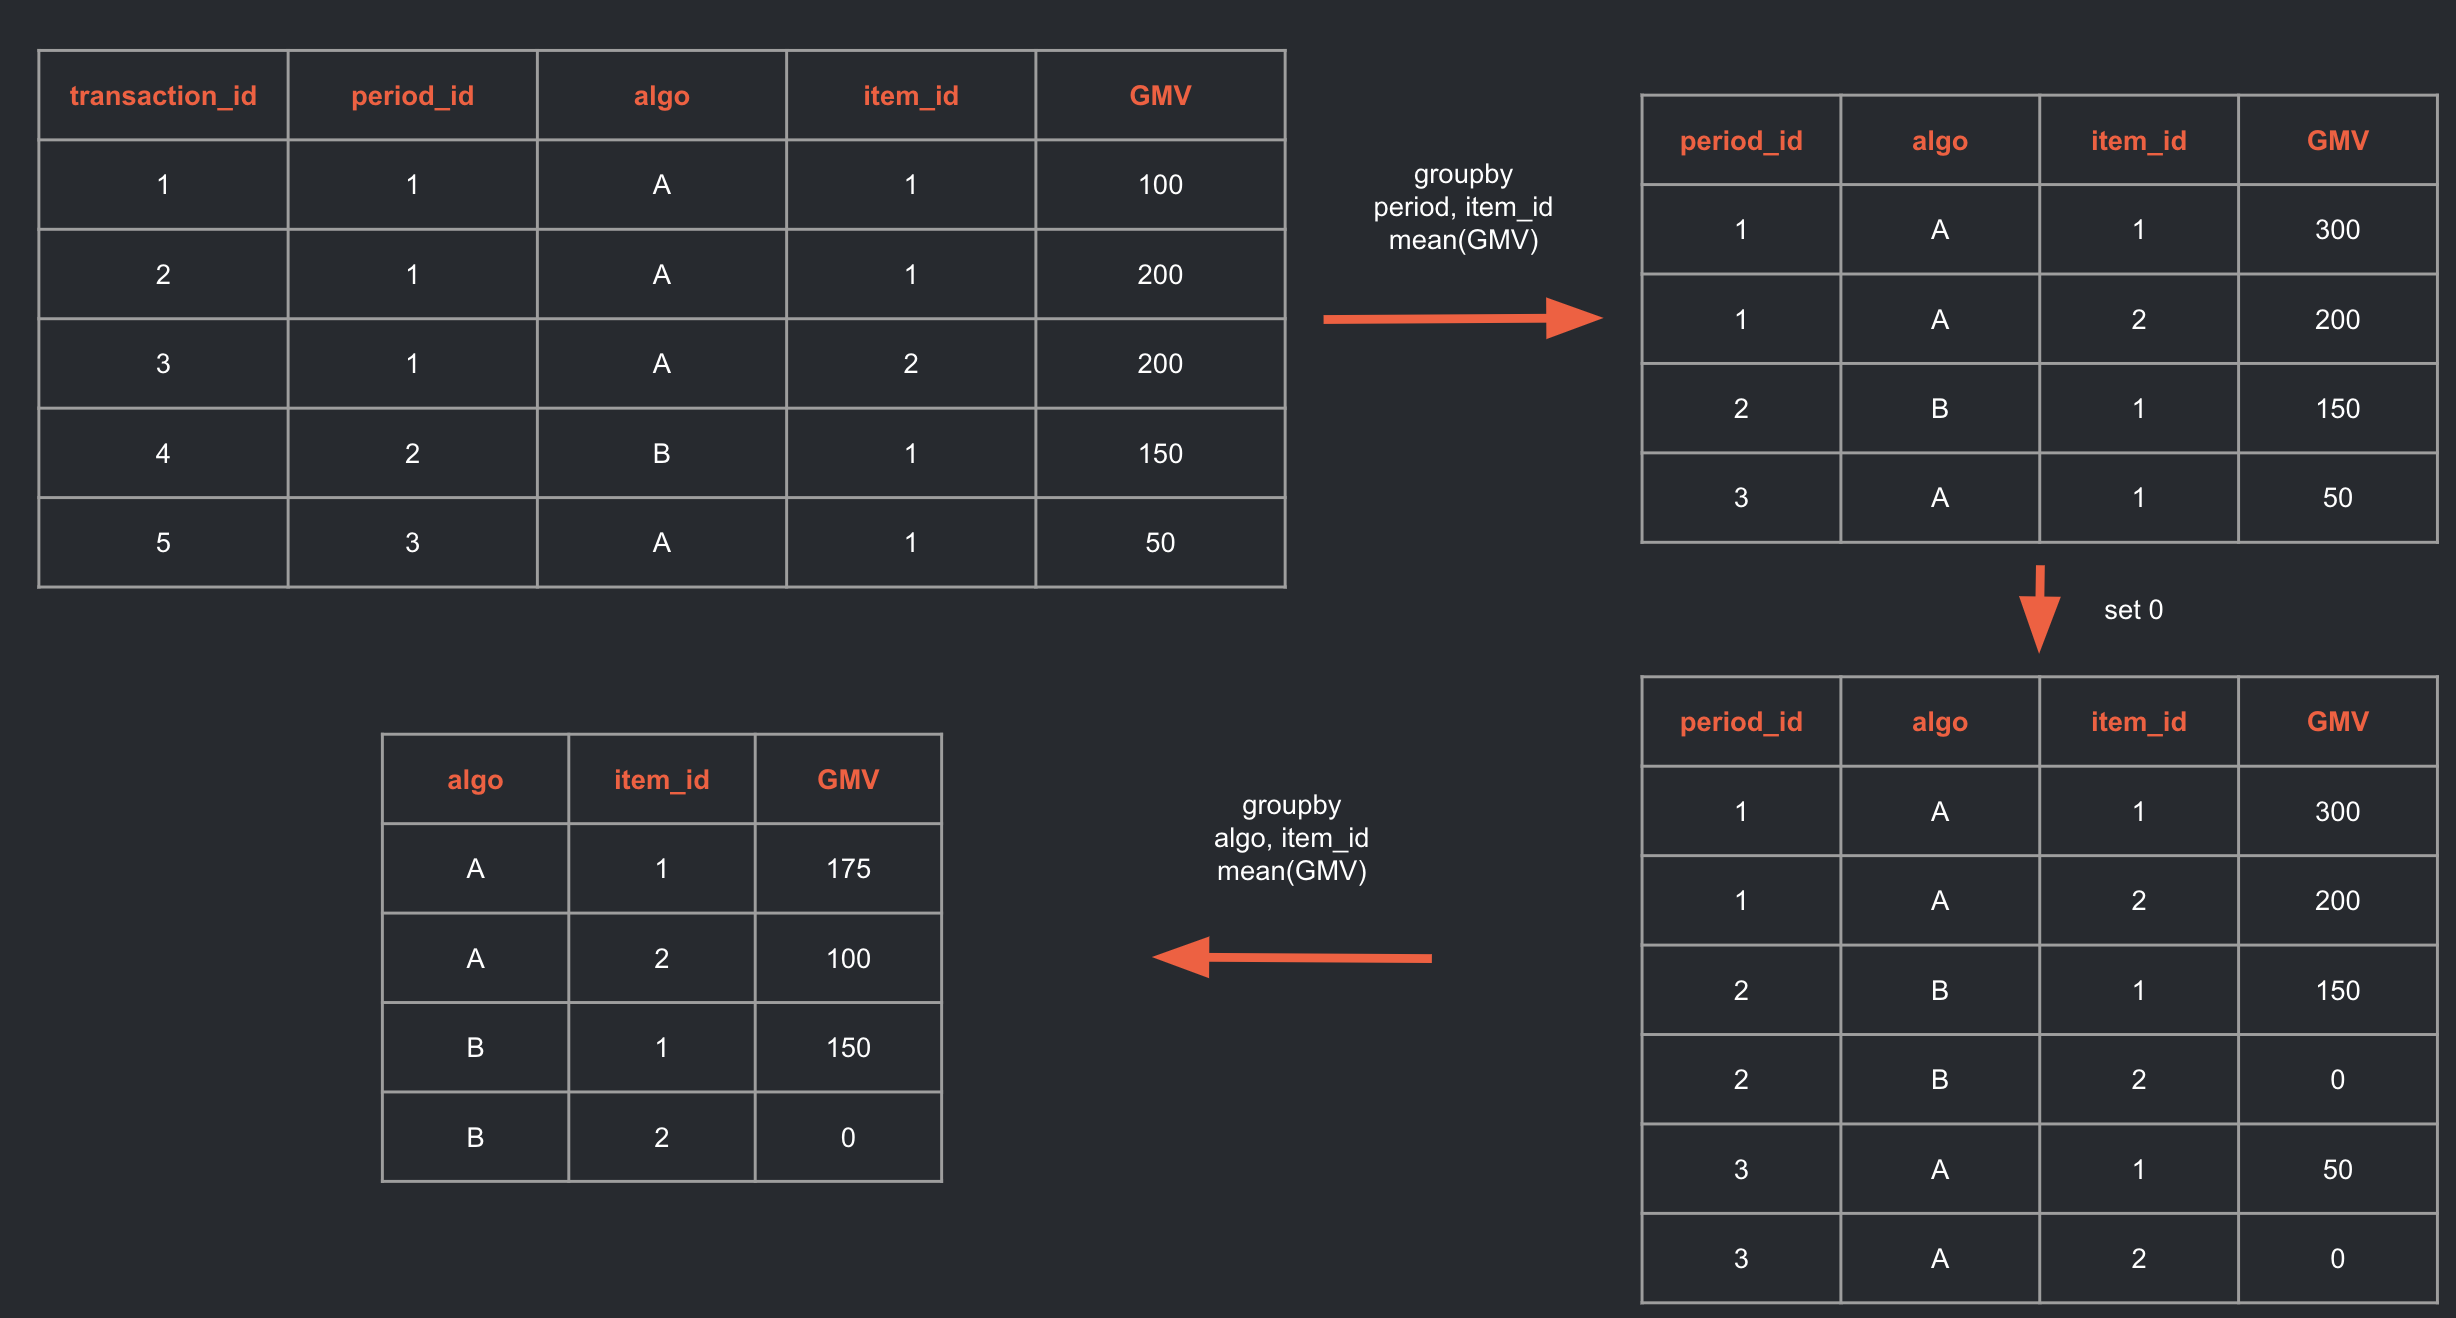

In [9]:
Image("./images/data_prepare.png", width=1000, height=400)

In [10]:
# Фильтрация датасета по дате
def get_sample_df(
    df: pd.DataFrame,
    start_dt: datetime,
    end_dt: datetime,
):

    # Отбор строк датасета, где время платежа находится в заданном диапазоне
    df = df[df["pay_time"].between(start_dt, end_dt)].reset_index(drop=True)

    logger.info(f"Test period: {df.pay_time.min().strftime('%d.%m.%Y %H:%M')} - {df.pay_time.max().strftime('%d.%m.%Y %H:%M')}")
    logger.info(f"Number of rows: {df.shape}")
    logger.info(f"Number of unique item_id: {df['item_id'].nunique()}")

    return df


# Расстановка периодов на транзакции
def set_period_index(
    periods_df: pd.DataFrame,
    pay_time: datetime,
):

    # Фильтрация DataFrame с периодами для нахождения подходящего периода для времени платежа
    filtered = periods_df[(periods_df["from"] <= pay_time) & (pay_time < periods_df["to"])]

    # Проверка, что найден ровно один подходящий период
    assert filtered.shape[0] == 1

    # Возврат индекса найденного периода
    return filtered["period_index"].tolist()[0]
    

# Агрегация данных
def aggregate_dataset(
    df: pd.DataFrame,
    items_df: pd.DataFrame,
    periods_df: pd.DataFrame,
    group_by: List[str],
    statistic_column: str,
    do_log: bool = True,
):

    # Создание таблицы с ключами
    key_df = items_df.merge(periods_df, how="cross")

    # Считаем средний чек по товарам и периодам
    df = df.groupby(group_by).mean().reset_index()

    # Если товар не продавался ставим 0
    df = pd.merge(key_df, df, how="left", on=group_by)

    df[statistic_column] = df[statistic_column].fillna(0.0)

    if do_log:
        logger.info(f"Number of rows: {df.shape}")
        logger.info(f"Number of unique item_id: {df['item_id'].nunique()}")

    # Проверка, что количество строк в результате соответствует ожидаемому
    assert df.shape[0] == items_df.shape[0] * periods_df.shape[0]

    return df

### Разделение на тестовые группы

In [11]:
def devide(
    df: pd.DataFrame,
    statistic_column: str,
    group_by: List[str],
    algo_a: str,
    algo_b: str,
    n_samples: int,
    replace: bool = False,
) -> Tuple[np.array, np.array]:

    # Считаем средний чек на товар
    a_values = df[df["algo"] == algo_a].groupby(group_by).mean()[statistic_column]
    b_values = df[df["algo"] == algo_b].groupby(group_by).mean()[statistic_column]
    
    # Выборка индексов товаров из a_values и получение соответствующих значений для обеих групп
    indexes = a_values.sample(n=n_samples, replace=replace).index

    return a_values.loc[indexes].values, b_values.loc[indexes].values

### Подсчет статистик

In [12]:
start_dt = datetime(year=2018, month=2, day=6, hour=14)  # Начало тестового периода
end_dt = datetime(year=2018, month=2, day=20, hour=14)  # Конец тестового периода
period = {"hours": 6}  # Размер подпериода

algo_a = "A"
algo_b = "B"
algo_list = [algo_a, algo_b]
algo_probabilities = [0.5, 0.5]  # Вероятности выбора алгоритмов

n_epochs = 100  # Следует поставить больше, но для простоты берем не много итераций
n_samples = 3_000  # Количество семплированных товаров для сравнения
replace = True  # Семплирование с возвращением

effects = np.arange(0.20, 0.42, 0.01).round(2).tolist()  # 0 - для АА симуляции, остальное - для АБ симуляции
statistic_column = "gmv"
group_by = ["item_id"]

In [13]:
# Словарь для сбора статистических данных теста
ab_statistics_dict = {
    "statistic": [],
    "p_value": [],
    "metric": [],
    "effect": [],
}

logger.info(f"Test period: {start_dt.strftime('%d.%m.%Y %H:%M')} - {end_dt.strftime('%d.%m.%Y %H:%M')}, {(end_dt - start_dt).days} days") 

# Получение DataFrame с периодами и список периодов для теста
periods_df, periods = get_periods(
    start_dt=start_dt,
    end_dt=end_dt,
    period=period,
)

# Фильтрация исходного DataFrame по дате для получения тестовой выборки
sample_df = get_sample_df(
    df=df,
    start_dt=start_dt,
    end_dt=end_dt,
)

# Присвоение индекса периода каждой транзакции в тестовой выборке
sample_df["period_index"] = sample_df["pay_time"].apply(lambda cell: set_period_index(periods_df=periods_df, pay_time=cell))

# Итерация по эпохам для выполнения теста
for epoch in tqdm(range(n_epochs)):

    # Случайное назначение алгоритмов периодам и повторное распределение
    epoch_periods = set_algo_randomly(periods=periods, algo_list=algo_list, probabilities=algo_probabilities)
    epoch_periods = repeat_distribution(periods=periods)
    epoch_periods_df = get_periods_df(periods=periods, do_log=False)
    
    # Агрегация данных
    epoch_sample_df = aggregate_dataset(
        df=sample_df,
        items_df=items_df,
        periods_df=epoch_periods_df,
        group_by=["period_index"] + group_by,
        statistic_column=statistic_column,
        do_log=False,
    )
    
    # Разделение агрегированных данных на две группы
    a_values, b_values = devide(
        df=epoch_sample_df,
        statistic_column=statistic_column,
        group_by=group_by,
        algo_a=algo_a,
        algo_b=algo_b,
        n_samples=n_samples,
    )
    
    # Итерация по различным эффектам для модификации данных группы B
    for effect in effects:
        b_values_with_effect = b_values * (1 + effect)  # Модификация значений группы B
        # Используется t-тест Уэлча, который не предполагает равенство дисперсий между двумя группами
        statistic, p_value = ttest_ind(a_values, b_values_with_effect, equal_var=False)
        ab_statistics_dict["statistic"].append(statistic)
        ab_statistics_dict["p_value"].append(p_value)
        ab_statistics_dict["metric"].append("t_statistic")
        ab_statistics_dict["effect"].append(effect)

INFO:switchback:Test period: 06.02.2018 14:00 - 20.02.2018 14:00, 14 days
INFO:switchback:Кол-во всего периодов: 56
INFO:switchback:Кол-во периодов для `None`: 56
INFO:switchback:Test period: 06.02.2018 14:00 - 20.02.2018 13:59
INFO:switchback:Number of rows: (152989, 4)
INFO:switchback:Number of unique item_id: 4265
100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


In [14]:
ab_statistics_df = pd.DataFrame(ab_statistics_dict)
ab_statistics_df.head()

,statistic,p_value,metric,effect
0,-1.061462,0.288525,t_statistic,0.20
1,-1.123835,0.261130,t_statistic,0.21
2,-1.185559,0.235846,t_statistic,0.22
3,-1.246642,0.212580,t_statistic,0.23
4,-1.307091,0.191235,t_statistic,0.24


# Результат

Посчитаем для каждого эффекта, в скольких случаях были прокрасы

In [15]:
keys_df = ab_statistics_df[["effect"]].drop_duplicates()
result_df = ab_statistics_df.copy(deep=True)
result_df["Тест прокрасился"] = result_df["p_value"] < 0.05
result_df = (
    result_df[result_df["Тест прокрасился"]]
    .groupby("effect")
    .agg({"p_value": "count"})
    .rename(columns={"p_value": "Количество прокрасов"})
).reset_index()
result_df["Процент прокрасов"] = result_df["Количество прокрасов"] / n_epochs * 100
result_df = keys_df.merge(result_df, on=["effect"], how="left")
result_df = result_df.fillna(0.0)
result_df

,effect,Количество прокрасов,Процент прокрасов
0,0.20,17,17.0
1,0.21,19,19.0
2,0.22,26,26.0
3,0.23,30,30.0
4,0.24,33,33.0
5,0.25,38,38.0
6,0.26,44,44.0
7,0.27,49,49.0
8,0.28,55,55.0
9,0.29,58,58.0
